# Assignment 3: Predicting the probability of default of credit card clients

**Deadline**:  Tue 10-Dec 2019, 23:59

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.|Vien Dinh       |11002115             |viendinh17@gmail.com        |
|2.|Jorrim Prins        |11038934              |jorrim.prins@hotmail.com         |
|3.|        |              |         |

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.
3. We shall not engage in any other activities that will dishonestly improve my results or dishonestly improve or hurt the results of others.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
3. Most of your answers will consist of code. Make sure your code is well structured, efficient and provided with comments where needed. These aspects will be taken into account in the grading of your work.
4. Sometimes you are asked to explain your code or to motivate your choices. Please be concise and use your own words in answering those questions.
5. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together.

## Goal
The goal of this assignment is to predict the probability of default of credit card clients using
- logistic regression
- neural network
- random forest
- AdaBoost

Using the techniques mentioned above, we ask you to come up with a model that has the best generalization performance.


## Test set
There are 30,000 observations, but for only the first 25,000 the target values are given. The other 5,000 target values will be used to assess your performance. The assignment is also a competition:  your mark (20%) depends on how well your model does on the test set compared to those of other groups.

# Initialize and get the data

First, we initialize some libraries, define an overlay histogram & a nice graphical confusion matrix, and read the data.

In [245]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def draw_histogram(varname):
    x0=df[varname][df.Y==0]
    x1=df[varname][df.Y==1]
    count0, bin_limits = np.histogram(x0,bins=30)
    count1, _          = np.histogram(x1,bins=bin_limits)
    plt.hist(x0,bins=bin_limits,color='LightBlue')
    plt.hist(x1,bins=bin_limits,color='DarkRed')
    ### normalized overlay histogram
    count_tot=count0+count1
    with np.errstate(divide='ignore',invalid='ignore'):
        count0rel=np.where(count_tot==0,np.nan,count0/(count0+count1))
        count1rel=np.where(count_tot==0,np.nan,count1/(count0+count1))
    labels=np.round((bin_limits[1:]+bin_limits[:-1])/2,1)    # determine middle of classes
    DataFrame({'0':count0rel,'1':count1rel},index=labels)[['1','0']].plot.bar(stacked=True,color=('DarkRed','LightBlue'));

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
df = pd.read_csv('MLE_Assignment3_data2019.csv')
df_labels=['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3',
'BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default payment next month']
df.columns
df_t=df['Y']                # select target variabel (as pandas series)
df_X=df.loc[:,'X1':'X23']   # select features (as pandas dataframe)

## Rate of default: around 22%

0.0    0.78012
1.0    0.21988
Name: Y, dtype: float64


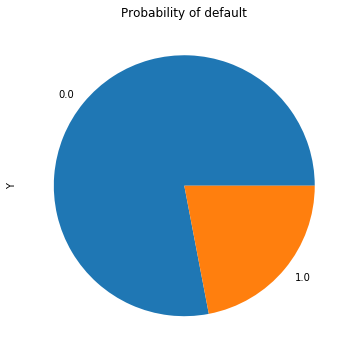

In [246]:
freq=df_t.value_counts()/(len(df_t)-df_t.isnull().sum())
freq.plot(kind='pie',title='Probability of default',figsize=(6, 6)); 
print(freq)

## Definition of variables

This assignment employs a binary variable, default payment (Yes = 1, No = 0), as the response variable `t` in October 2005 from an important bank in Taiwan. The data consist of the following 23 variables as explanatory variables: 

- `X1`: Amount of the given credit (NT dollar=New Taiwan $): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- `X2`: Gender (1 = male; 2 = female). 
- `X3`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- `X4`: Marital status (1 = married; 2 = single; 3 = others). 
- `X5`: Age (years). 
- `X6 - X11`: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: `X6` = the repayment status in September, 2005; `X7` = the repayment status in August, 2005; . . .;`X11` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- `X12-X17`: Amount of bill statement (NT dollar). `X12` = amount of bill statement in September, 2005; `X13` = amount of bill statement in August, 2005; . . .; `X17` = amount of bill statement in April, 2005. 
- `X18-X23`: Amount of previous payment (NT dollar). `X18` = amount paid in September, 2005; `X19` = amount paid in August, 2005; . . .;`X23` = amount paid in April, 2005. 

# Creating features

Some variable (at least `X2`-`X4`) have to be dummified. We start with `X1` and add columns to the dataframe. Also add X5 (age) to the dataframe, does not have to be dummified.

In [247]:
data=pd.DataFrame(df['X1'],columns=['X1'])
X2_dum=pd.get_dummies(df['X2'], prefix='X2',drop_first=True)
data=pd.merge(data,X2_dum,left_index=True, right_index=True)
X3_dum=pd.get_dummies(df['X3'], prefix='X3',drop_first=True)
data=pd.merge(data,X3_dum,left_index=True, right_index=True)
X4_dum=pd.get_dummies(df['X4'], prefix='X4',drop_first=True)
data=pd.merge(data,X4_dum,left_index=True, right_index=True)

## Should `X6-X17` be dummified?

You can use `draw_histogram()` to create overlay histograms. The first histogram shows the absolute frequencies, where red bars indicate defaults. The second one shows the normalized frequencies. In this way we can judge whether the effect is linear or not. Below, we look at the variable `X6`.

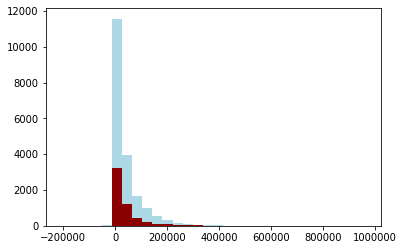

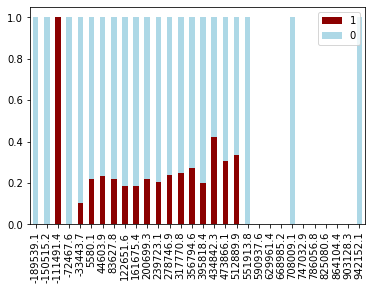

In [248]:
draw_histogram('X17')

## X6-X11 Have to be dummified



<span style="color:red"> Histograms, and specifically the normalized histograms, show a significant difference in default rate when discrete values for X6-X11 are 2 or higher, so we decide to create dummies that have value 1 for X# >= 2 and 0 for X# < 2. See below.</span>

In [249]:
df['X6'] = np.array(df['X6'] >= 2).astype(int)
df['X7'] = np.array(df['X7'] >= 2).astype(int)
df['X8']= np.array(df['X8'] >= 2).astype(int)
df['X9'] = np.array(df['X9'] >= 2).astype(int)
df['X10'] = np.array(df['X10'] >= 2).astype(int)
df['X11'] = np.array(df['X11'] >= 2).astype(int)

## Finalizing the features

Below, we choose to not dummify the variables `X6`-`X17` out of convenience. Whether this is justified is up to you.<BR> Furthermore, non-dummy variables are standardized.<BR>
Some procedures require numpy array/matrix, so this is also defined. `Xlabels[i]` gives the label of `X[:,i]`.

<span style="color:red"> As mentioned above, we have dummified variables X6-X11</span>

In [250]:
data=pd.merge(data,df.loc[:,'X5':'X23'],left_index=True, right_index=True)

cols = list(data.columns)
for col in cols:   # loop over all columns
    if np.abs(data[col].mean())>1:    # check if dummy
        data[col] = (data[col] - data[col].mean())/data[col].std(ddof=1)   # no dummy: than standardize
t=df_t.values   # convert to numpy array
X=data.values   # convert to numpy matrix
Xlabels=data.columns
data.describe()

,X1,X2_2,X3_1,X3_2,X3_3,X3_4,X3_5,X3_6,X4_1,X4_2,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,-1.905890e-15,0.603733,0.352833,0.467667,0.163900,0.004100,0.009333,0.001700,0.455300,0.532133,...,-1.715295e-17,1.658303e-17,6.371570e-17,-3.479069e-17,-4.753753e-16,2.400626e-16,5.278648e-17,1.159776e-16,2.276105e-16,-9.278837e-16
std,1.000000e+00,0.489129,0.477859,0.498962,0.370191,0.063901,0.096159,0.041197,0.498006,0.498975,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.213774e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.945623e+00,-3.314993e+00,-2.000840e+00,-6.355141e+00,-3.419359e-01,-2.569852e-01,-2.967963e-01,-3.080574e-01,-3.141309e-01,-2.933772e-01
25%,-9.054832e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.394708e-01,-6.363187e-01,-6.340494e-01,-6.316233e-01,-2.815614e-01,-2.208321e-01,-2.746460e-01,-2.891632e-01,-2.976042e-01,-2.867536e-01
50%,-2.118290e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,-3.882465e-01,-3.763388e-01,-3.652622e-01,-3.660664e-01,-2.151494e-01,-1.697923e-01,-1.945640e-01,-2.123096e-01,-2.159525e-01,-2.090007e-01
75%,5.588978e-01,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.896426e-01,1.747637e-01,1.624928e-01,1.733968e-01,-3.970110e-02,-3.997954e-02,-4.093162e-02,-5.188424e-02,-5.026000e-02,-6.837322e-02
max,6.416421e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.331781e+01,1.318647e+01,1.458719e+01,1.549502e+01,5.239834e+01,7.284177e+01,5.059444e+01,3.933152e+01,2.760317e+01,2.944461e+01


## Create undummified dataset and preprocess

<span style="color:red">We create a similar dataset without all the dummies to check this in our random forest models.</span>

In [251]:
data_undum = df_X

cols = list(data_undum.columns)
for col in cols:   # loop over all columns
    if np.abs(data_undum[col].mean())>1:    # check if dummy
        data_undum[col] = (data_undum[col] - data_undum[col].mean())/data_undum[col].std(ddof=1)   # no dummy: than standardize
X_undum=data_undum.values   # convert to numpy matrix
Xlabels_undum=data.columns
data_undum.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04
mean,-1.905890e-15,1.207508e-15,-5.744868e-16,-5.824082e-16,-9.309960e-17,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,-1.715295e-17,1.658303e-17,6.371570e-17,-3.479069e-17,-4.753753e-16,2.400626e-16,5.278648e-17,1.159776e-16,2.276105e-16,-9.278837e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.123802,1.197186,1.196868,1.169139,1.133187,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.213774e+00,-1.234302e+00,-2.344704e+00,-2.973098e+00,-1.571453e+00,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.945623e+00,-3.314993e+00,-2.000840e+00,-6.355141e+00,-3.419359e-01,-2.569852e-01,-2.967963e-01,-3.080574e-01,-3.141309e-01,-2.933772e-01
25%,-9.054832e-01,-1.234302e+00,-1.079439e+00,-1.057277e+00,-8.120610e-01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-6.394708e-01,-6.363187e-01,-6.340494e-01,-6.316233e-01,-2.815614e-01,-2.208321e-01,-2.746460e-01,-2.891632e-01,-2.976042e-01,-2.867536e-01
50%,-2.118290e-01,8.101472e-01,1.858252e-01,8.585430e-01,-1.611538e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.882465e-01,-3.763388e-01,-3.652622e-01,-3.660664e-01,-2.151494e-01,-1.697923e-01,-1.945640e-01,-2.123096e-01,-2.159525e-01,-2.090007e-01
75%,5.588978e-01,8.101472e-01,1.858252e-01,8.585430e-01,5.982379e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.896426e-01,1.747637e-01,1.624928e-01,1.733968e-01,-3.970110e-02,-3.997954e-02,-4.093162e-02,-5.188424e-02,-5.026000e-02,-6.837322e-02
max,6.416421e+00,8.101472e-01,5.246883e+00,2.774363e+00,4.720650e+00,8.000000,8.000000,8.000000,8.000000,8.000000,...,2.331781e+01,1.318647e+01,1.458719e+01,1.549502e+01,5.239834e+01,7.284177e+01,5.059444e+01,3.933152e+01,2.760317e+01,2.944461e+01


## Training and validation set
Note that the test set (last 5,000 observations) cannot be used to assess the predictive accuracy of your model. <BR>
Hence, we split out sample (first 25,000 observations) into a training and validation set.<BR>
You could also use cross-validation (on the first 25K obs.), but for now we keep it simple.

<span style="color:red">As we have 25000 observations to train and validate our model, training and validation set are large enough and we choose not to use cross-validation. This would be very time consuming and unnecessary.</span>

In [252]:
from sklearn.model_selection import train_test_split

#Create training and validation set for our preprocessed dataset.
X_train, X_val, t_train, t_val = train_test_split(X[:25000], t[:25000], random_state=1, test_size=0.25)

#Create training and validation set for undummified dataset.
Xun_train, Xun_val, tun_train, tun_val = train_test_split(X_undum[:25000], t[:25000], random_state=1, test_size=0.25)

## Oversamplen

<span style="color:red"> The dataset contains only 22% defaults, which makes the dataset very unbalanced. We tried to rebalance the dataset with SMOTE but this decreased the accuracy significantly.</span>

In [253]:
from imblearn.over_sampling import SMOTE
#Resample training data
#X_train, t_train = SMOTE(0.5).fit_resample(X_train, t_train)


<span style="color:red">Show oversampled frequencies in our trainingset</span>

0.0    0.778187
1.0    0.221813
dtype: float64


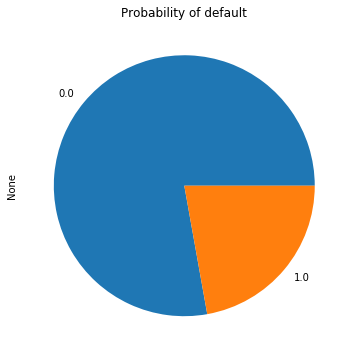

In [254]:
prr = pd.Series(t_train.reshape(-1))


freq=prr.value_counts()/(len(prr)-prr.isnull().sum())
freq.plot(kind='pie',title='Probability of default',figsize=(6, 6)); 
print(freq)


# Logistic regression

Let's start with a basic logistic regression as our baseline.

<span style="color:red">For a simple logistic regression, we compare undummified and dummified data, which shows an increase in accuracy and confirms our expectation.</span>

Accuracy Logistic regression dummified: 0.824


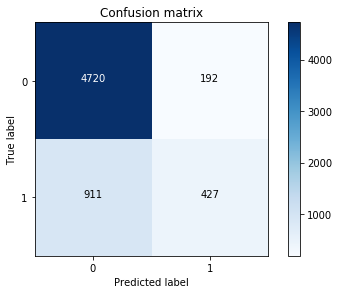

Accuracy Logistic regression undummified: 0.815


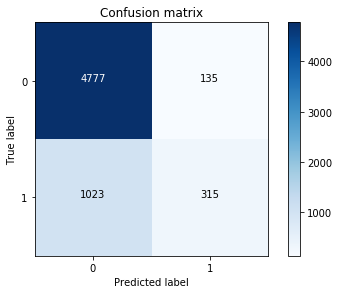

In [255]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Train model on our processed data
clf = LogisticRegression(random_state=1, solver='lbfgs',C=1E9,max_iter=1000)    # almost no regularization
clf.fit(X_train, t_train)     # fit the model
t_pred=clf.predict(X_val)     # predict taget variable for the validation set
acc_LR=accuracy_score(t_val, t_pred)   # determine accuracy
print(f'Accuracy Logistic regression dummified: {acc_LR:.3f}')
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()


#Train model on undummified data
clf = LogisticRegression(random_state=1, solver='lbfgs',C=1E9,max_iter=1000)    # almost no regularization
clf.fit(Xun_train, tun_train)     # fit the model
tun_pred=clf.predict(Xun_val)     # predict taget variable for the validation set
acc_2=accuracy_score(tun_val, tun_pred)   # determine accuracy
print(f'Accuracy Logistic regression undummified: {acc_2:.3f}')
cnf_matrix = confusion_matrix(tun_val, tun_pred)
class_names = [0,1]; plt.figure()

plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()

# Basic Neural Network (one-hidden-layer neural network )

- Note: you can just use `Keras` to train your Network.
- Did you check convergence?

<span style="color:red">We use a simple model with 2 hidden units, stochastic gradient descent optimizer and batch_size of 128. The plots show that it converges within 500 epochs.</span>

In [272]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ActivityRegularization

model = Sequential()
model.add(Dense(units=2,activation='tanh')) #hidden layer
model.add(Dense(units=1, activation='tanh')) #output layer

sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=False) #sgd classifier                     
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy']) #compile model

history = model.fit(X_train,t_train,epochs=int(100),batch_size=128,verbose=0,validation_data=(X_val,t_val))

Accuracy NN: 0.817


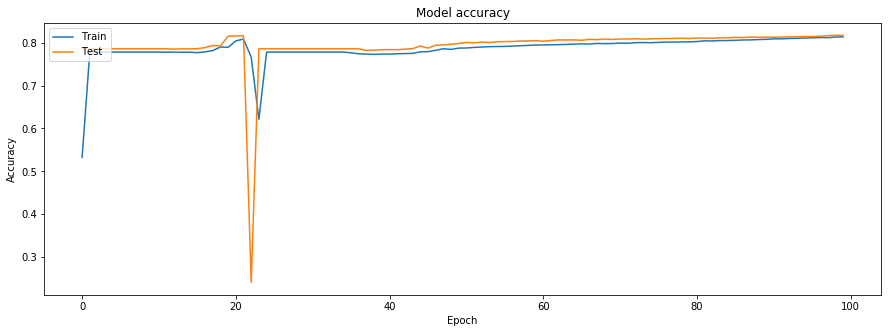

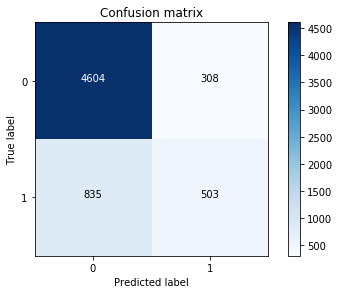

In [273]:
#Visualize results
loss, acc_NN = model.evaluate(X_val,t_val,verbose=0)
print(f'Accuracy NN: {acc_NN:.3f}')
# Plot training & validation accuracy values
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,1,1) 
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

t_pred=model.predict_classes(X_val)     # predict taget variable for the validation set
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()


# Basic Random forest

- Also try to use undummified data, so let the decision tree decide on the splitting.

<span style="color:red">Both dummified and undummified data did not reach a high accuracy as the Neural Network did.</span>

Accuracy with RF: 0.811 


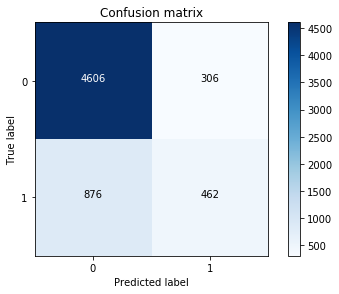

In [227]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=20, bootstrap=True, max_features='auto', criterion="entropy",
        max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42)

rf.fit(X_train, t_train.ravel())
t_pred=rf.predict(X_val)


acc_RF = accuracy_score(t_val,t_pred)
print(f'Accuracy with RF: {acc_RF:.3f} ')

cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()

Accuracy with RF with undummified data: 0.813 


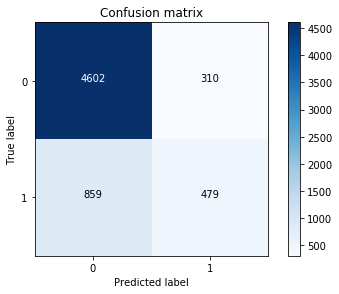

In [228]:
rf = RandomForestClassifier(n_estimators=20, bootstrap=True, max_features='auto', criterion="entropy",
        max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42)

rf.fit(Xun_train, tun_train.ravel())
tun_pred=rf.predict(Xun_val)

acc_RF2 = accuracy_score(tun_val,tun_pred)
print(f'Accuracy with RF with undummified data: {acc_RF2:.3f} ')

cnf_matrix = confusion_matrix(tun_val, tun_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()


### Gridsearch

<span style="color:red">We've also gridsearched Random Forests with undummified data, als undummified data reached higher accuracy in the random forest. However, this did not result in higher accuracy.</span>

In [139]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 60, 80, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 4],
    'n_estimators': [200, 500, 1000]
}

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)

rf_grid.fit(Xun_train, tun_train.ravel())
print(rf_grid.best_params_)

t_pred=rf_grid.best_estimator_.predict(Xun_val)
acc_gridRF = accuracy_score(tun_val,t_pred)
print(f'Accuracy with RF and gridsearch: {acc_gridRF:.3f} ')
    

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min


KeyboardInterrupt: 

# Basic AdaBoost

In [229]:
# starter code
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# simple fit
AdaB = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators=50, 
    learning_rate=0.5,
)
AdaB.fit(X_train,t_train.ravel())

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

Accuracy with AdaBoost: 0.784 


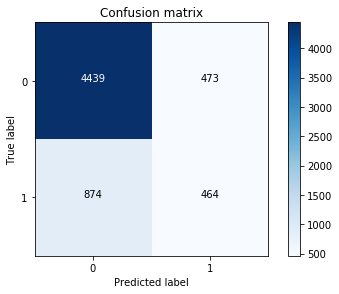

In [230]:
t_pred=AdaB.predict(X_val)
acc_ada = accuracy_score(t_val,t_pred)
print(f'Accuracy with AdaBoost: {acc_ada:.3f} ')

cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()



### Gridsearch

In [143]:
param_grid = {
    "base_estimator__max_depth" : [1,2,5,None],
    "n_estimators": [1,2,10,20,50],
}

AdaB_grid = GridSearchCV(estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 5)
AdaB_grid.fit(X_train, t_train.ravel())
print(AdaB_grid.best_params_)

t_pred=AdaB_grid.best_estimator_.predict(X_val)
acc_adagrid = accuracy_score(t_val,t_pred)

print(f'Accuracy with AdaBoost: {acc_adagrid:.3f} ')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


{'base_estimator__max_depth': None, 'n_estimators': 50}
Accuracy with AdaBoost: 0.787 


# Advanced Classifier

**Choose one** of the above basic classifiers (which seems most promising to you) and optimize as much as possible. You can think of:
- optimize hyper parameters/regularization using CV validation
- optimize your dummification/binning with respect to the target variable
- including interactions between (transformed) features.

Please  make  sure  all  steps  are  well  motivated  and  presented  in  a  clear and structured way.

In [269]:
#Basic model accuracies
print(f'Accuracy with LR dummified: {acc_LR:.3f}')
print(f'Accuracy with LR undummified: {acc_2:.3f} \n')
print(f'Accuracy with NN dummified: {acc_NN:.3f} \n')
print(f'Accuracy with RF dummified: {acc_RF:.3f} ')
print(f'Accuracy with RF undummified: {acc_RF2:.3f} \n')
print(f'Accuracy with AdaBoost dummified: {acc_ada:.3f} ')


Accuracy with LR dummified: 0.824
Accuracy with LR undummified: 0.815 

Accuracy with NN dummified: 0.824 

Accuracy with RF dummified: 0.811 
Accuracy with RF undummified: 0.813 

Accuracy with AdaBoost dummified: 0.784 


## Introduction
Our research started with the investigation of the given X-variables. A couple of variables (X2-X4) had to be dummified immediately. Other variables seemed to behave better when converted into binary variables (X6-X11). We started by creating a dummified and an undummified dataset, because Random Forests behave better with undummified data for example. 

The 4 models we consider afterwards are Logistic Regression, Neural Network, Random Forest and AdaBoost. The above block shows a couple of found accuracy scores for the models, trained with dummified and undummified data. Only Random Forest seems to behave better with undummified data, however it has lower accuracy than Logistic Regression and Neural Network (NN has around 0.823 accuracy with undummified data in simple model). AdaBoost also has a very low accuracy compared to the other models.

## Basic models

### Logistic Regression
Although the accuracy of the logistic regression model with dummified features shows a decent accuracy score,
the model is confined in its possibilities and this is why we will not advance with this model.

### Random Forest
When trying out the Random Forest, we found that it barely (or negatively) reacted to preprocessing of the dataset, such as interaction terms and dummies. The fact that the RF model does not have a lot of preprocsessing possibilities and has a relatively low accuracy (even when gridsearched) resulted in not advancing this model.

### Adaboost
Adaboost has a significantly lower accuracy, even with the application of a gridsearch. This model will not be used either. 

### Extra tests
As mentioned before, we've tried undummified and dummified data for random forest, and we've also gridsearched the Random Forest and AdaBoost model over its parameters. These methods did not result in a better accuracy. 

## Advanced Classifier: Neural Network
We choose to continue with the Neural Network as it promises to be the appropriate model to have the most accurate prediction, due to the versatility of the parameters and the information that can be extracted from the model.

### Data preprocessing
With regard to preprocessing the data, we choose to convert X6-11 to binary variables as mentioned before. From the histograms plotted earlier in the script, we observed that X6-X11 have a jump in credit default for payment delays of two months or longer. This is why we we dummify X6-X11 to be 0 for values smaller than 2 and 1 for values of 2 or higher. 

Including interaction terms in the data results in a network that starts overfitting, as the training accuracy is not followed by it's test accuracy. We decide not to include interaction terms as part of data preprocessing.

### The network
We use a sequential network as we have binary targets. Trial and error shows that the highest accuracy resulted from a network with 1 hidden layer and 5 units, where the 'adam' optimizer is used and batch size is set to 500 (which seems to be optimal). Activation functions for the model are tanh functions.

### Optimiser
For the optimiser, we choose the Adam optimiser with the optimal parameters suggested by the original paper. This allows the use of higher batch size, which results in a batch-gradient that is more similar to the gradient of the total dataset. The optimisers RMSprop and SGD turned out to not be robust enough to handle the higher batch size.(See source 1 below). 

### Additional information 
Other options that we have tried, but resulted in less accurate models are 
Dense models with multiple layers
Dense models with layers that contain a lot of units, followed by dropout to find the optimal combination of units.
Dense models in combination with L1 and L2 regularization
Dense models with optimisers RMSprop and SGD.

1. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

## Neural Network Advanced

In [274]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ActivityRegularization

model = Sequential()
model.add(Dense(units=5,activation='tanh')) #hidden layer
model.add(Dense(units=1, activation='tanh')) #output layer

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, amsgrad=False) #adam optimizer

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) #compile model

history = model.fit(X_train,t_train,epochs=int(1000),batch_size=500,verbose=0,validation_data=(X_val,t_val))

Accuracy: 0.828


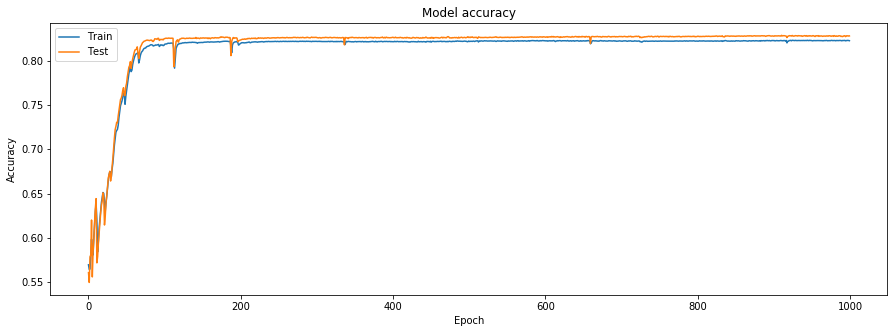

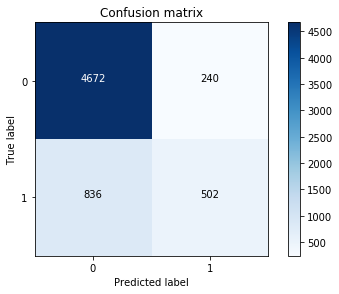

In [275]:
#Visualize results
loss, acc = model.evaluate(X_val,t_val,verbose=0)
print(f'Accuracy: {acc:.3f}')
# Plot training & validation accuracy values
fig = plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,1,1) 
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

t_pred=model.predict_classes(X_val)     # predict target variable for the validation set
cnf_matrix = confusion_matrix(t_val, t_pred)
class_names = [0,1]; plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix');plt.show()


# Finally, generate your predictions for the test set and save them into your notebook

Generate predictions for the last 5,000 observations (of the csv-file):
- use the correct X-values! For instance, if you don't change the numpy matrix `X`, you can use `X[-5000:]` to make the predictions
- think what properties your predictions should have (continuous or discrete)
- of course, you can't determine the accuracy
- if you have performed some transformations, please be sure to apply them also on the last 5K obs (as is done in the example above)
- save your predictions in the variable `t_pred` and save them into your notebook using `%store t_pred`

In [276]:
t_pred=model.predict_classes(X[-5000:])
%store t_pred

Stored 't_pred' (ndarray)
